In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(tree,
                           data, target,
                           n_jobs=-1
)
scores = cv_results['test_score']
scores.mean(), scores.std()

(np.float64(0.353754868050922), np.float64(0.08746975066961293))

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 8, None],
    'min_samples_split': [2, 10, 30, 50],
    'min_samples_leaf': [0.01, 0.05, 0.1, 1]
}
cv = 3

tree_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1
)


In [5]:
cv_results = cross_validate(tree_grid, data, target, n_jobs=-1, return_estimator=True)
scores = cv_results['test_score']
scores.mean(), scores.std()

(np.float64(0.5231879144209726), np.float64(0.10735694468283409))

In [6]:
# Bagged tree
from sklearn.ensemble import BaggingRegressor

tree = DecisionTreeRegressor()
bagging_regressor = BaggingRegressor(
    estimator=tree, n_estimators=20, random_state=0
)
cv_results = cross_validate(bagging_regressor, data, target, n_jobs=-1, return_estimator=True)
scores = cv_results['test_score']
scores.mean(), scores.std()

(np.float64(0.6415552840813044), np.float64(0.08304406575978997))

In [7]:
def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    rng = np.random.default_rng(1)  # Create a random number generator
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.normal(size=(n_samples,))
    y = x**3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"]
    )
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

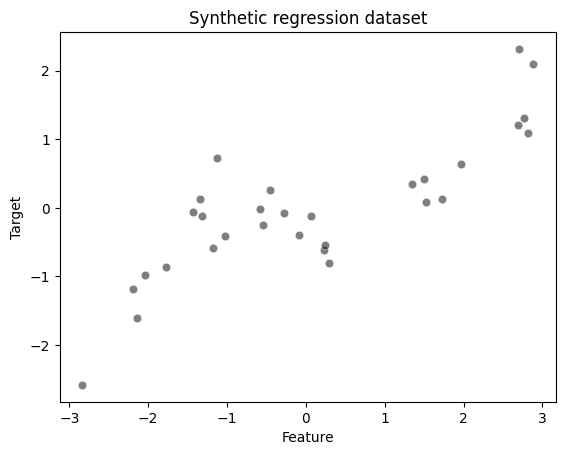

In [8]:
data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
_ = plt.title("Synthetic regression dataset")

In [9]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

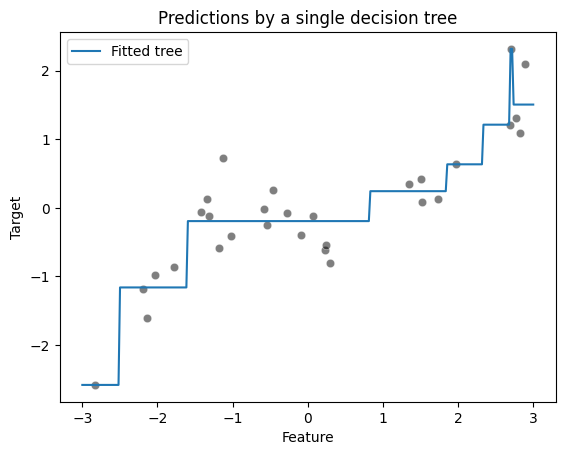

In [10]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

In [11]:
# choose n_sample (size) from n data points (np.arange as an array)
def bootstrap_sample(data, target, seed=0):
    rng = np.random.default_rng(seed)
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]),
        size=target.shape[0],
        replace=True,
    )

    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

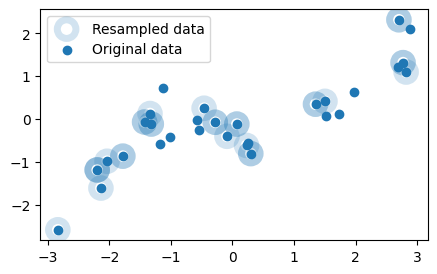

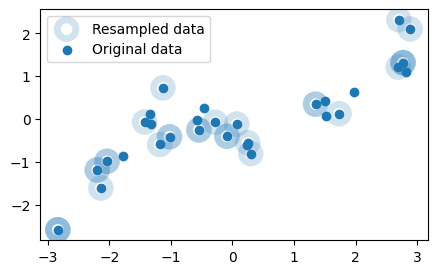

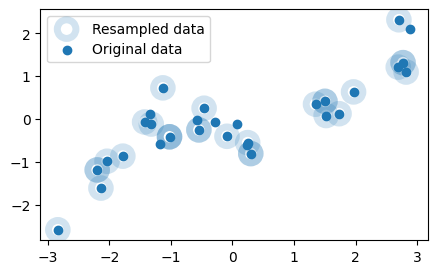

In [12]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train, target_train, seed=bootstrap_idx
    )
    plt.figure(figsize=(5,3))
    plt.scatter(data_bootstrap['Feature'], target_bootstrap,
                color='tab:blue', alpha=0.2, label='Resampled data',
                s=180, facecolor='none', linewidth=5)
    plt.scatter(data_train['Feature'], target_train, label="Original data")
    plt.legend()

In [13]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000
)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge
)

ratio_unique_sample = (
    np.unique(data_bootstrap_sample).size / data_bootstrap_sample.size
)
print(
    "Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


In [14]:
bag_of_tree = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)
    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train, seed=bootstrap_idx
    )
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_tree.append(tree)

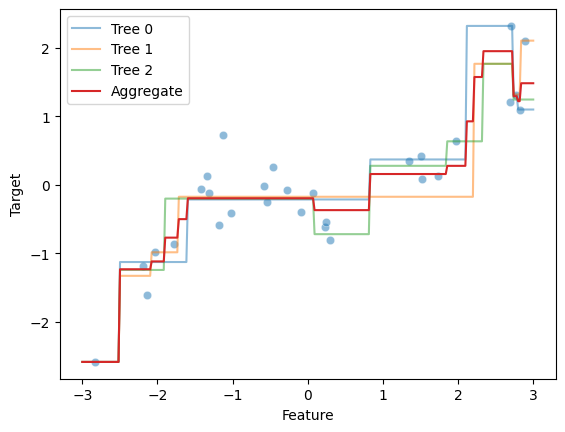

In [15]:
sns.scatterplot(
    x=data_train['Feature'], y=target_train, alpha=0.5
)
bag_predictions = []
for tree_idx, tree in enumerate(bag_of_tree):
    tree_predictions = tree.predict(data_test)
    plt.plot(
        data_test['Feature'],
        tree_predictions,
        alpha=0.5,
        label=f"Tree {tree_idx}"
    )
    bag_predictions.append(tree_predictions)
bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(
    data_test['Feature'], bag_predictions,
    label='Aggregate'
)
plt.legend()

In [16]:
bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)

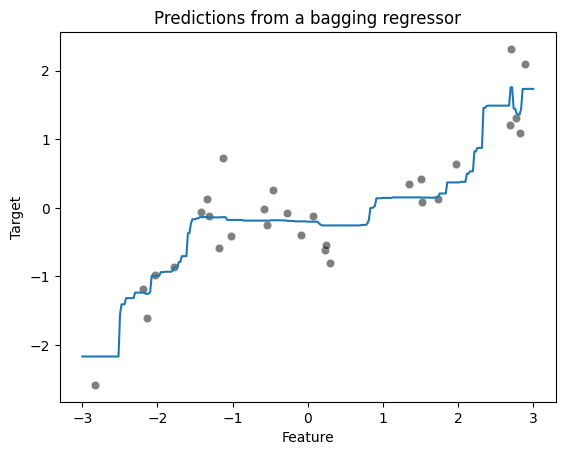

In [17]:
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions)

_ = plt.title("Predictions from a bagging regressor")

In [18]:
len(bagged_trees.estimators_)

100

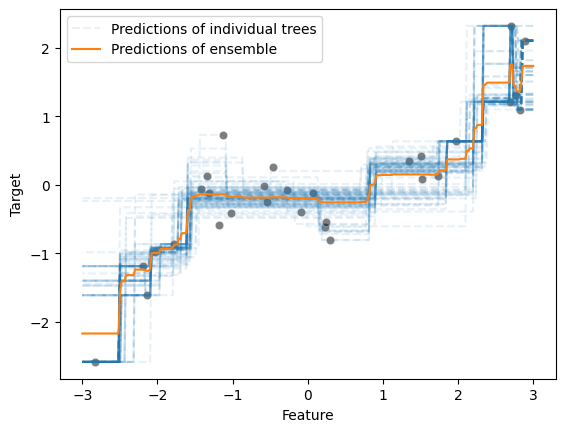

In [19]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(
        data_test["Feature"],
        tree_predictions,
        linestyle="--",
        alpha=0.1,
        color="tab:blue",
        label=label,
    )

sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(
    data_test["Feature"],
    bagged_trees_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
_ = plt.legend()

In [20]:
# Let's fit a bagged Ridge regression model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4, include_bias=False),
    Ridge(alpha=1e-10)
)
polynomial_regressor

,steps,"[('minmaxscaler', ...), ('polynomialfeatures', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,degree,4
,interaction_only,False
,include_bias,False
,order,'C'


In [21]:
bagging = BaggingRegressor(
    estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0
)
_ = bagging.fit(data_train, target_train)

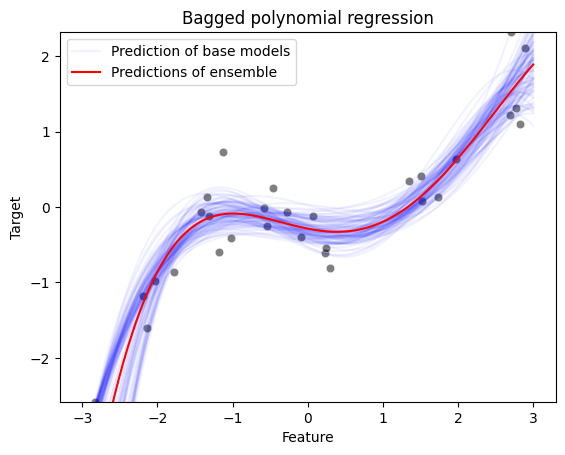

In [22]:
for i, regressor in enumerate(bagging.estimators_):
    regressor_pred = regressor.predict(data_test.to_numpy())
    base_model_line = plt.plot(
        data_test['Feature'],
        regressor_pred,
        alpha=0.05,
        label="Prediction of base models" if i==0 else None,
        color='blue'
    )
sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
bagging_predictions = bagging.predict(data_test)
plt.plot(
    data_test["Feature"],
    bagging_predictions,
    color="red",
    label="Predictions of ensemble",
)
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")  

In [23]:
# Exercise 6.01
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5
)

In [24]:
from sklearn.metrics import mean_absolute_error
bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor()
)
bagged_trees.fit(data_train, target_train)
predictions = bagged_trees.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mae

36.893994544573644

In [25]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'n_estimators': [20, 50, 100, 200],
    'max_samples': [0.5, 0.75, 1.0],    
    'estimator__max_depth': randint(3, 10)
}

bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor()
)
bagged_trees_search = RandomizedSearchCV(
    bagged_trees,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    n_jobs=-1
)

In [26]:
bagged_trees_search.fit(data_train, target_train)
predictions = bagged_trees_search.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mae

39.79299453002984

In [27]:
bagged_trees_search.best_params_

{'estimator__max_depth': 9, 'max_samples': 0.5, 'n_estimators': 20}

In [28]:
# Random forest

adult_census = pd.read_csv("data/adult-census.csv")
target_name = "class"
data = adult_census.drop(columns=[target_name, "education-num"])
target = adult_census[target_name]

In [29]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

categorical_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value', unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder='passthrough'
)
preprocessor

,transformers,"[('ordinalencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,dtype,<class 'numpy.float64'>
,handle_unknown,'use_encoded_value'


In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))

In [31]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, data, target)
scores_tree.mean(), scores_tree.std()

(np.float64(0.8196840462681388), np.float64(0.005515265758252987))

In [32]:
# Bagged tree
from sklearn.ensemble import BaggingClassifier

bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        estimator=BaggingClassifier(random_state=0),
        n_estimators=50,
        n_jobs=-1,
        random_state=0        
    )
)
scores_bagged_tree = cross_val_score(bagged_trees, data, target)
scores_bagged_tree.mean(), scores_bagged_tree.std()

(np.float64(0.8546129535765118), np.float64(0.0038923064758358706))

In [33]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50,
                           n_jobs=-1,
                           random_state=0)
)
scores_random_forest = cross_val_score(random_forest, data, target)
scores_random_forest.mean(), scores_random_forest.std()

(np.float64(0.851152786199874), np.float64(0.003888344026376117))

In [34]:
random_forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinalencoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000020288822E40>)])),
  ('randomforestclassifier',
   RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0))],
 'transform_input': None,
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020288822E40>)]),
 'randomforestclassif

In [35]:
# Exercise M6.02
import pandas as pd
from sklearn.model_selection import train_test_split

penguins = pd.read_csv("data/penguins_regression.csv")
feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
data, target = penguins[[feature_name]], penguins[target_name]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

tree = RandomForestRegressor(n_estimators=3, n_jobs=-1, random_state=0)
tree.fit(data_train, target_train)
scores_tree = cross_val_score(tree, data_test, target_test)
scores_tree.mean(), scores_tree.std()

(np.float64(0.598353518697666), np.float64(0.18278151795023137))

In [37]:
tree.estimators_

[DecisionTreeRegressor(max_features=1.0, random_state=209652396),
 DecisionTreeRegressor(max_features=1.0, random_state=398764591),
 DecisionTreeRegressor(max_features=1.0, random_state=924231285)]

In [38]:
# Create an artificial dataset
data_sample = np.linspace(170, 230, len(data_train))


In [39]:
data_train.head()

,Flipper Length (mm)
306,187.0
101,183.0
153,210.0
341,198.0
81,187.0


c:\ESL\Learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


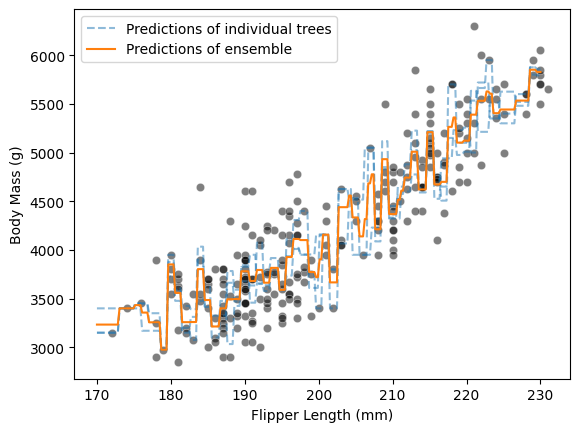

In [40]:
# Plot each tree's prediction, as well as the average
for tree_idx, t in enumerate(tree.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = t.predict(data_sample.reshape(-1, 1))
    plt.plot(
        data_sample,
        tree_predictions,
        linestyle="--",
        alpha=0.5,
        color="tab:blue",
        label=label,
    )

sns.scatterplot(
    x=data_train["Flipper Length (mm)"], y=target_train, color="black", alpha=0.5
)

random_forest_predictions = tree.predict(data_sample.reshape(-1, 1))
plt.plot(
    data_sample,
    random_forest_predictions,
    color="tab:orange",
    label="Predictions of ensemble",
)
_ = plt.legend()


In [41]:
# AdaBoost
penguins = pd.read_csv("data/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]

In [42]:
# Train a shallow tree
palette = ["tab:red", "tab:blue", "black"]

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [43]:
target_predicted = tree.predict(data)
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
data_misclassified = data.iloc[misclassified_samples_idx]
data_misclassified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 16 to 304
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Culmen Length (mm)  22 non-null     float64
 1   Culmen Depth (mm)   22 non-null     float64
dtypes: float64(2)
memory usage: 528.0 bytes


Text(0.5, 1.0, 'Decision tree predicioon\nwith misclassified samples highlighted')

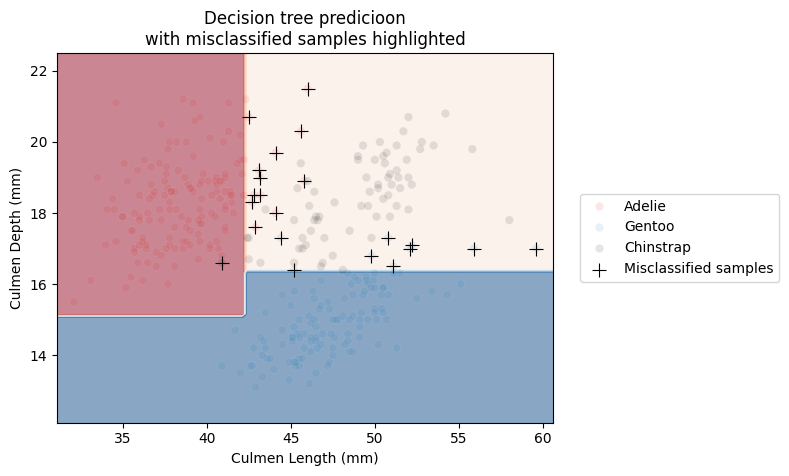

In [44]:
from sklearn.inspection import DecisionBoundaryDisplay

# Draw decision boundary
DecisionBoundaryDisplay.from_estimator(
    tree, data, response_method='predict', cmap='RdBu', alpha=0.5
)

# Draw all data points
sns.scatterplot(
    data=penguins,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=palette,
    alpha=0.1
)

# Draw mis-classified sample
sns.scatterplot(
    data=data_misclassified,
    x=culmen_columns[0],
    y=culmen_columns[1],
    label='Misclassified samples',
    marker='+',
    s=100,
    color='k'    
)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.title('Decision tree predicioon\nwith misclassified samples highlighted')

In [45]:
# Assign weight of 0/1 to corrected/incorrectly classified samples
sample_weight = np.zeros_like(target, dtype=int)
sample_weight[misclassified_samples_idx] = 1
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target, sample_weight=sample_weight)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [46]:
tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 0,
 'splitter': 'best'}

Text(0.5, 1.0, 'Decision tree predicioon\nwith misclassified samples highlighted')

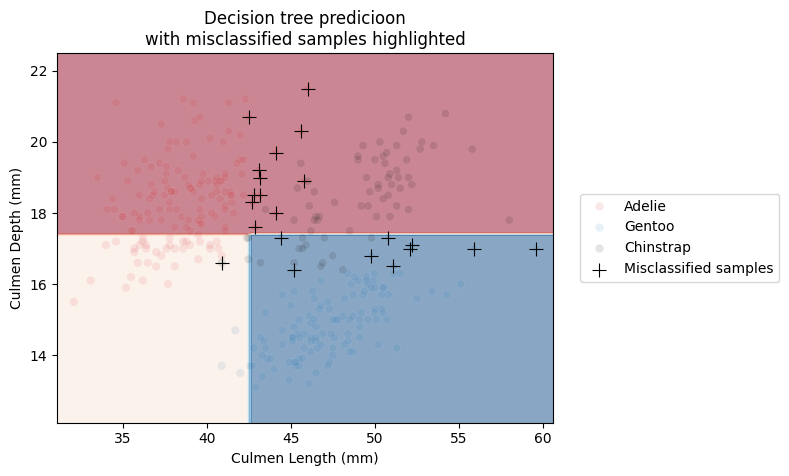

In [47]:
# Draw decision boundary
DecisionBoundaryDisplay.from_estimator(
    tree, data, response_method='predict', cmap='RdBu', alpha=0.5
)

# Draw all data points
sns.scatterplot(
    data=penguins,
    x=culmen_columns[0],
    y=culmen_columns[1],
    hue=target_column,
    palette=palette,
    alpha=0.1
)

# Draw mis-classified sample
sns.scatterplot(
    data=data_misclassified,
    x=culmen_columns[0],
    y=culmen_columns[1],
    label='Misclassified samples',
    marker='+',
    s=100,
    color='k'    
)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.title('Decision tree predicioon\nwith misclassified samples highlighted')

In [48]:
target_predicted = tree.predict(data)
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)
print("# of samples previously misclassified and"
      f"still misclassified: {len(remaining_misclassified_samples_idx)}")

# of samples previously misclassified andstill misclassified: 0


In [49]:
ensemble_weight = [
    (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
    (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

In [50]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(
    estimator=estimator, n_estimators=3, random_state=0
)
adaboost.fit(data, target)

,estimator,DecisionTreeC...andom_state=0)
,n_estimators,3
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,0
,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


<Figure size 640x480 with 0 Axes>

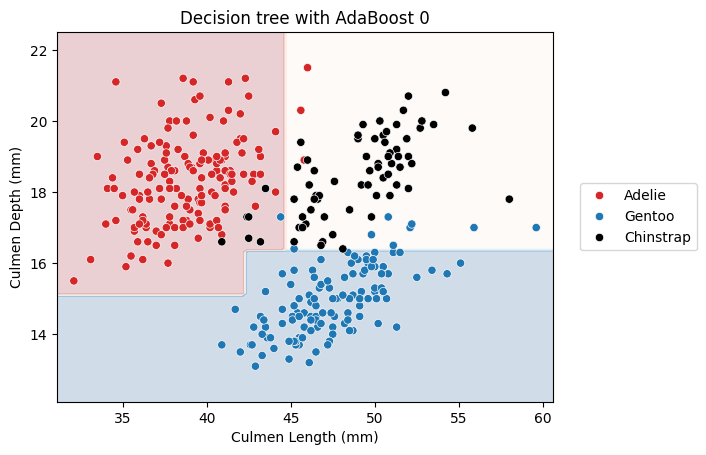

<Figure size 640x480 with 0 Axes>

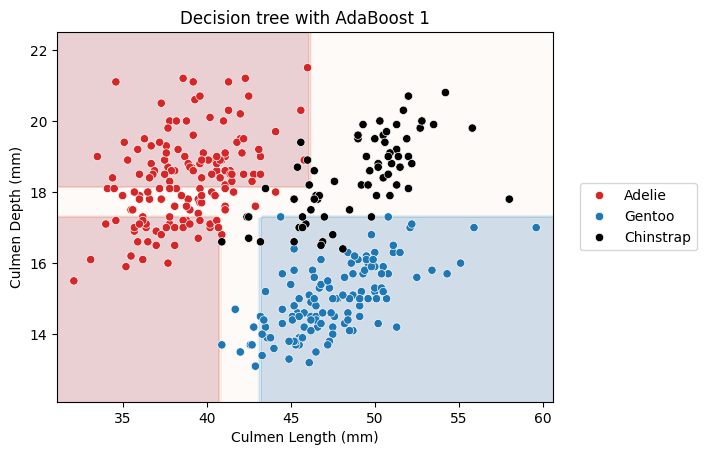

<Figure size 640x480 with 0 Axes>

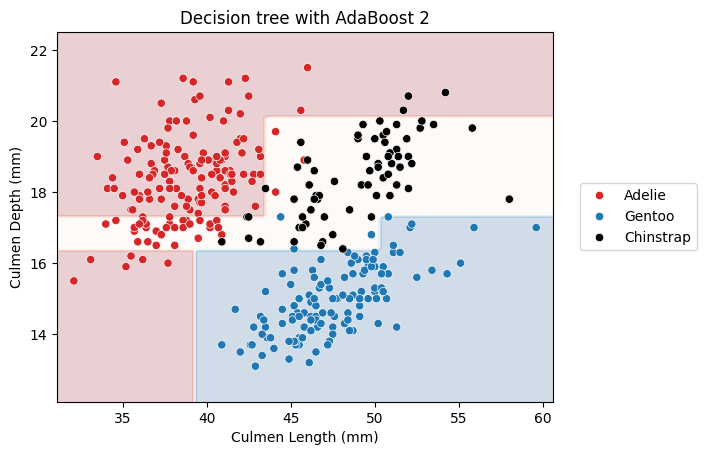

In [51]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    DecisionBoundaryDisplay.from_estimator(
        tree,
        data.to_numpy(),
        response_method='predict',
        cmap='RdBu',
        alpha=0.2
    )
    sns.scatterplot(
        data=penguins,
        x=culmen_columns[0],
        y=culmen_columns[1],
        hue=target_column,
        palette=palette
    )
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
    plt.title(f'Decision tree with AdaBoost {boosting_round}')

In [52]:
adaboost.estimator_errors_, adaboost.estimator_weights_

(array([0.05263158, 0.05864198, 0.08787269]),
 array([3.58351894, 3.46901998, 3.03303773]))

In [53]:
data.head()

,Culmen Length (mm),Culmen Depth (mm)
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0
3,36.7,19.3
4,39.3,20.6


In [54]:
# Gradient boosting
def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    rng = np.random.default_rng(0)  # Create a random number generator
    x = rng.uniform(x_min, x_max, size=(n_samples,))
    noise = rng.normal(size=(n_samples,)) * 0.3
    y = x**3 - 0.5 * x**2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"]
    )
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

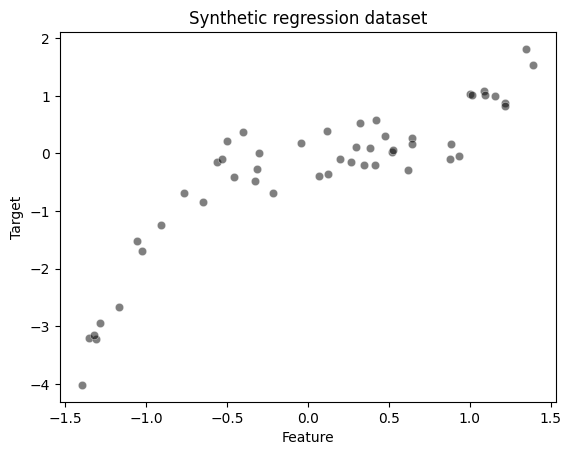

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
_ = plt.title("Synthetic regression dataset")

In [56]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

In [57]:

# Helper function

def plot_decision_tree_with_residuals(y_train, y_train_pred, y_test_pred):
    _fig_, ax = plt.subplots()
    
    # scatterplot training data
    sns.scatterplot(
        x=data_train['Feature'], y=y_train, alpha=0.5, ax=ax
    )
    
    # plot predictions/line plot
    line_predictions = ax.plot(data_test['Feature'], y_test_pred, '-')
    
    # plot the residuals
    # draw a vertical red line between the true and pred
    for value, true, predicted in zip(
        data_train['Feature'], y_train, y_train_pred
    ):
        lines_residuals = ax.plot(
            [value, value], [true, predicted], color='red'
        )
        
    # Prepare legend handles, to be passed to ax.legend(handles, labels)
    # line_predictions[0] and lines_residuals[0]: the line object
    handles = [line_predictions[0], lines_residuals[0]]
    
    return handles, ax

Text(0.5, 1.0, 'Decision tree')

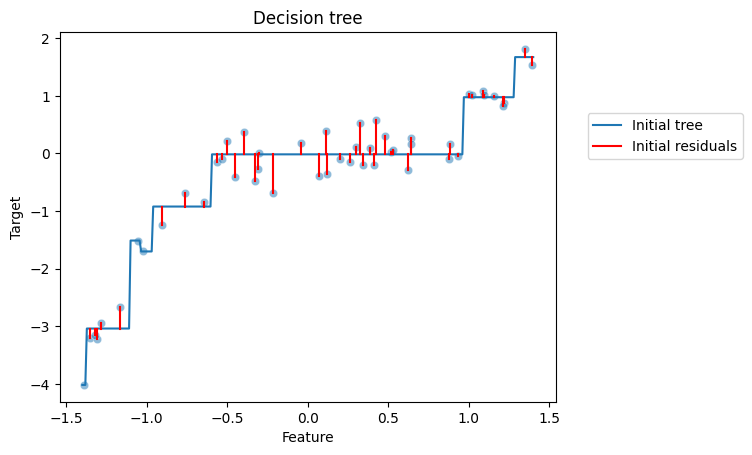

In [58]:
handles, ax = plot_decision_tree_with_residuals(
    target_train, target_train_predicted, target_test_predicted
)
legend_labels = ['Initial tree', 'Initial residuals']
ax.legend(handles, legend_labels, bbox_to_anchor=(1.05, 0.8), loc='upper left')
ax.set_title('Decision tree')

In [59]:
residuals = target_train - target_train_predicted

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

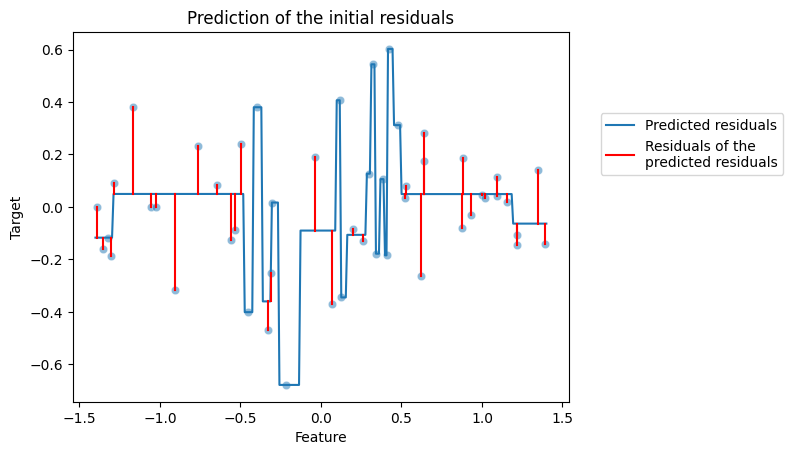

In [60]:
handles, ax = plot_decision_tree_with_residuals(
    residuals, target_train_predicted_residuals, target_test_predicted_residuals
)
legend_labels = [
    "Predicted residuals",
    "Residuals of the\npredicted residuals",
]
ax.legend(handles, legend_labels, bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = ax.set_title("Prediction of the initial residuals")

In [61]:
sample = data_train.iloc[[-7]] # sample df
x_sample = sample['Feature'].iloc[0] # transform to a number
target_true = target_train.iloc[-7]
target_true_residual = residuals.iloc[-7]


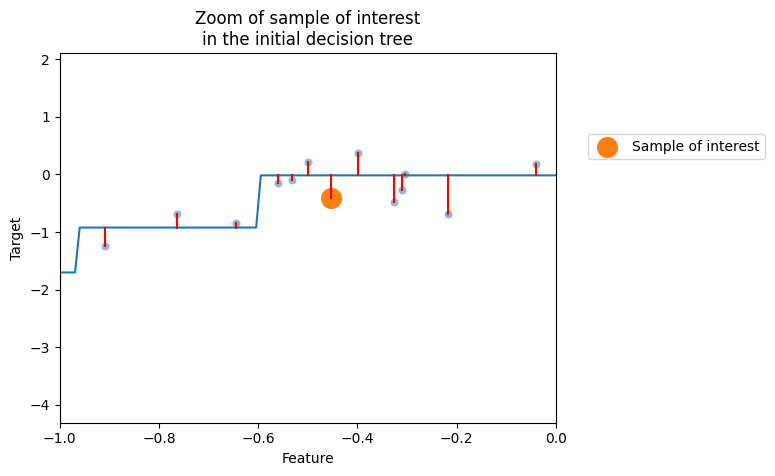

In [62]:
handles, ax = plot_decision_tree_with_residuals(
    target_train, target_train_predicted, target_test_predicted
)
ax.scatter(
    sample, target_true, label="Sample of interest", color="tab:orange", s=200
)
ax.set_xlim([-1, 0])
ax.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = ax.set_title("Zoom of sample of interest\nin the initial decision tree")

In [64]:
# Compare GBM with random forest
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [66]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=200)
cv_gbm = cross_validate(
    gbm, data, target, scoring='neg_mean_absolute_error', n_jobs=-1
)
cv_gbm['test_score'].mean(), cv_gbm['test_score'].std()

(np.float64(-46.411087127656494), np.float64(2.914178948101212))

In [68]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
cv_rf = cross_validate(rf, data, target, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_rf['test_score'].mean(), cv_rf['test_score'].std()

(np.float64(-46.415351174176344), np.float64(4.270593301753162))